In [292]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import harmonypy
import xgboost as xgb
from sklearn.utils import resample

In [93]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.7


In [94]:
adata = sc.read_h5ad(r'C:\Users\daany\temp\RGCatlas.h5ad')

In [95]:
adata.X = adata.layers['raw'].copy()
sc.pp.normalize_total(adata, inplace=True)

normalizing counts per cell
    finished (0:00:00)


In [96]:
sc.pp.log1p(adata)

In [97]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


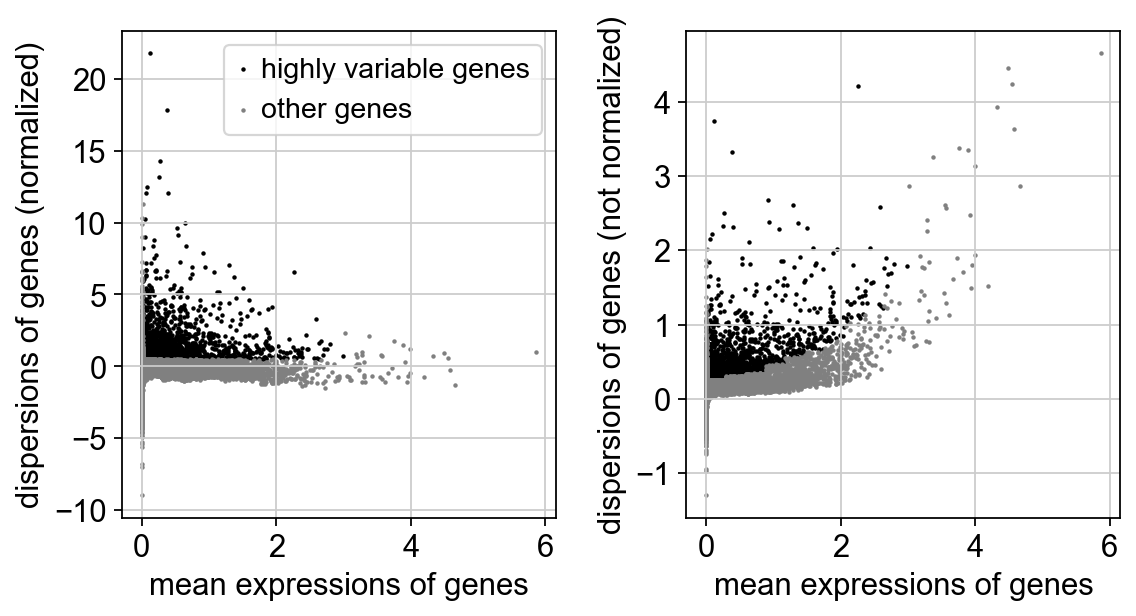

In [98]:
sc.pl.highly_variable_genes(adata)

In [99]:
adata = adata[:, adata.var.highly_variable]

In [100]:
sc.external.pp.harmony_integrate(adata, key='Batch')

2022-12-23 11:51:46,626 - harmonypy - INFO - Iteration 1 of 10
2022-12-23 11:52:00,943 - harmonypy - INFO - Iteration 2 of 10
2022-12-23 11:52:14,351 - harmonypy - INFO - Iteration 3 of 10
2022-12-23 11:52:28,558 - harmonypy - INFO - Iteration 4 of 10
2022-12-23 11:52:35,429 - harmonypy - INFO - Iteration 5 of 10
2022-12-23 11:52:40,713 - harmonypy - INFO - Iteration 6 of 10
2022-12-23 11:52:46,651 - harmonypy - INFO - Converged after 6 iterations


In [101]:
sc.pp.scale(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [102]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


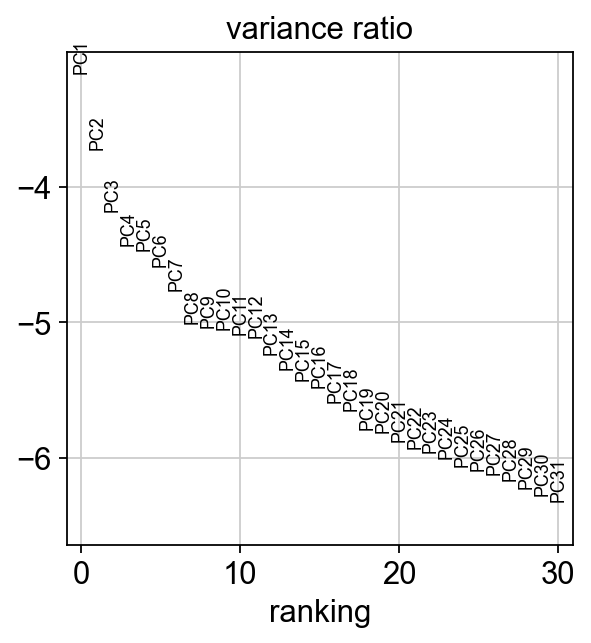

In [103]:
sc.pl.pca_variance_ratio(adata, log=True)

In [104]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)


In [105]:
sc.tl.leiden(adata, resolution=1.2)

running Leiden clustering
    finished: found 44 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


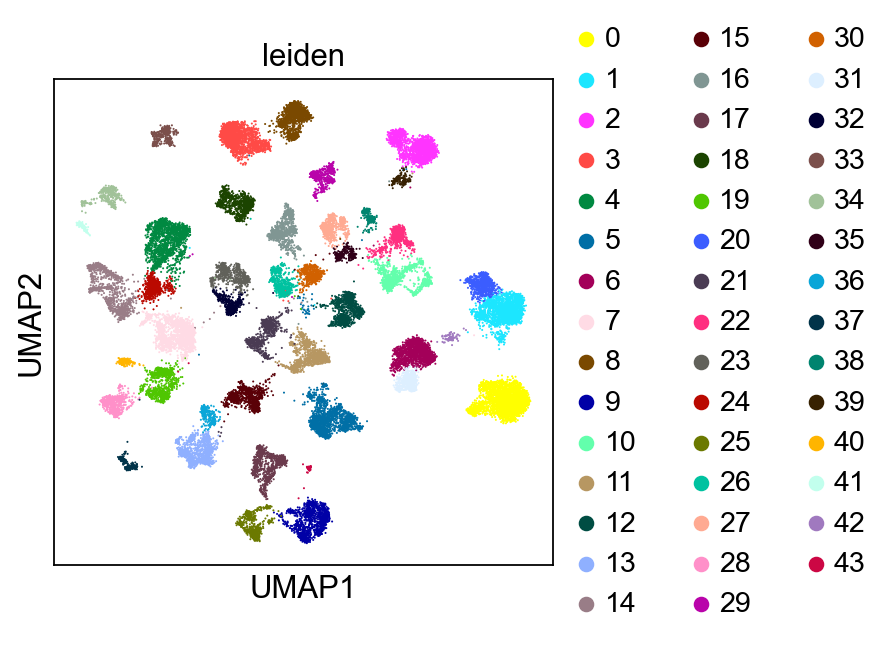

In [106]:
sc.pl.umap(adata, color=['leiden'])

In [109]:
# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

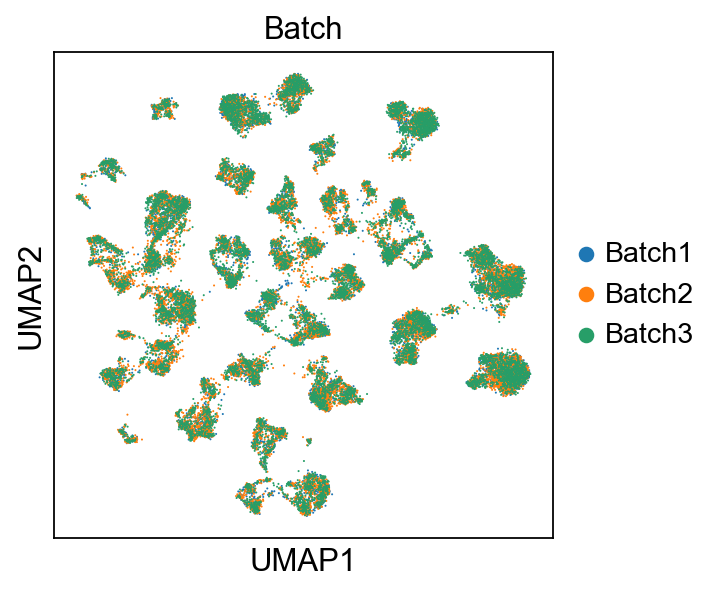

In [110]:
sc.pl.umap(adata, color=['Batch'])

In [ ]:
y_labels = []

first_run = True
for group in map_dict.values():
    if adata[adata.obs['Type_int'] == group].n_obs < 100:
        target = 300
        upsample = resample(adata[adata.obs['Type_int'] == group].X, replace=True, n_samples=target)
        new_matrix = np.append(new_matrix, upsample, axis=0)
        y_labels = np.append(y_labels, np.repeat(group, target))
    elif adata[adata.obs['Type_int'] == group].n_obs > 2000:
        target = 2000
        df = pd.DataFrame(adata.X, adata.obs['Type_int']).reset_index().rename(columns={'Type_int': 'index'})
        downsample = df[df['index'] == group].loc[np.random.choice(df[df['index'] == group].index, size=target, replace=False), :]
        if first_run:
            new_matrix = downsample.iloc[:, 1:].to_numpy()
            y_labels = np.append(y_labels, np.repeat(group, target))
            first_run = False
        else:
            new_matrix = np.append(new_matrix, downsample.iloc[:, 1:].to_numpy(), axis=0)
            y_labels = np.append(y_labels, np.repeat(group, target))
    else:
        new_matrix = np.append(new_matrix, adata[adata.obs['Type_int'] == group].X, axis=0)
        y_labels = np.append(y_labels, np.repeat(group, len(adata[adata.obs['Type_int'] == group].X)))

In [631]:
map_dict = {}
for i in range(1, len(np.unique(adata.obs['Type_num'])) + 1):
    map_dict[i-1] = f"C{i}"
map_dict = {v: k for k, v in map_dict.items()}
adata.obs['Type_int'] = adata.obs['Type_num'].map(map_dict).astype('int')

In [632]:
new_matrix = adata.X
y_labels = adata.obs['Type_int'].to_numpy()

for group in map_dict.values():
    length = adata[adata.obs['Type_int'] == group].n_obs
    if length > 2000:
        current = length
        target = 2000
        random_indices = np.random.choice(np.where(y_labels == group)[0], size=current-target, replace=False)
        new_matrix = np.delete(new_matrix, random_indices, axis=0)
        y_labels = np.delete(y_labels, random_indices)
    elif length < 100:
        current = length
        target = 300
        upsample = resample(adata[adata.obs['Type_int'] == group].X, replace=True, n_samples=target-current)
        new_matrix = np.append(new_matrix, upsample, axis=0)
        y_labels = np.append(y_labels, np.repeat(group, target-current))

In [633]:
n = len(new_matrix)
train_frac = .7
n_train = int(train_frac * n)
random_indices = np.random.choice(list(range(0, n)), size=n_train, replace=False)

X_train = new_matrix[random_indices]
X_valid = np.delete(new_matrix, random_indices, axis=0)

y_train = y_labels[random_indices]
y_valid = np.delete(y_labels, random_indices)

In [634]:
train_matrix = xgb.DMatrix(data=X_train, label=y_train)

In [635]:
number_train_classes = len(np.unique(adata.obs['Type_num']))
eta = .3
xgb_params_train_RGC = {
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': number_train_classes, # look for class labels {0, 1,..., number_train_classes - 1}
    'eta': eta, # learning rate
    'max_depth': 4,
    'subsample': .6
}
n_round = 10

In [636]:
bst_model_train = xgb.train(params=xgb_params_train_RGC, dtrain=train_matrix, num_boost_round=n_round)

In [637]:
validation_matrix = xgb.DMatrix(data=X_valid, label=y_valid)

In [638]:
validation_probs = bst_model_train.predict(data=validation_matrix)

In [639]:
y_pred = np.argmax(validation_probs, axis=1)
accuracy = np.sum(y_pred==y_valid) / len(y_pred)
print(accuracy)

0.9416391532336376


In [640]:
preds = np.argmax(bst_model_train.predict(data=xgb.DMatrix(data=adata.X, label=adata.obs['Type_int'])), axis=1)
adata.obs['preds'] = preds

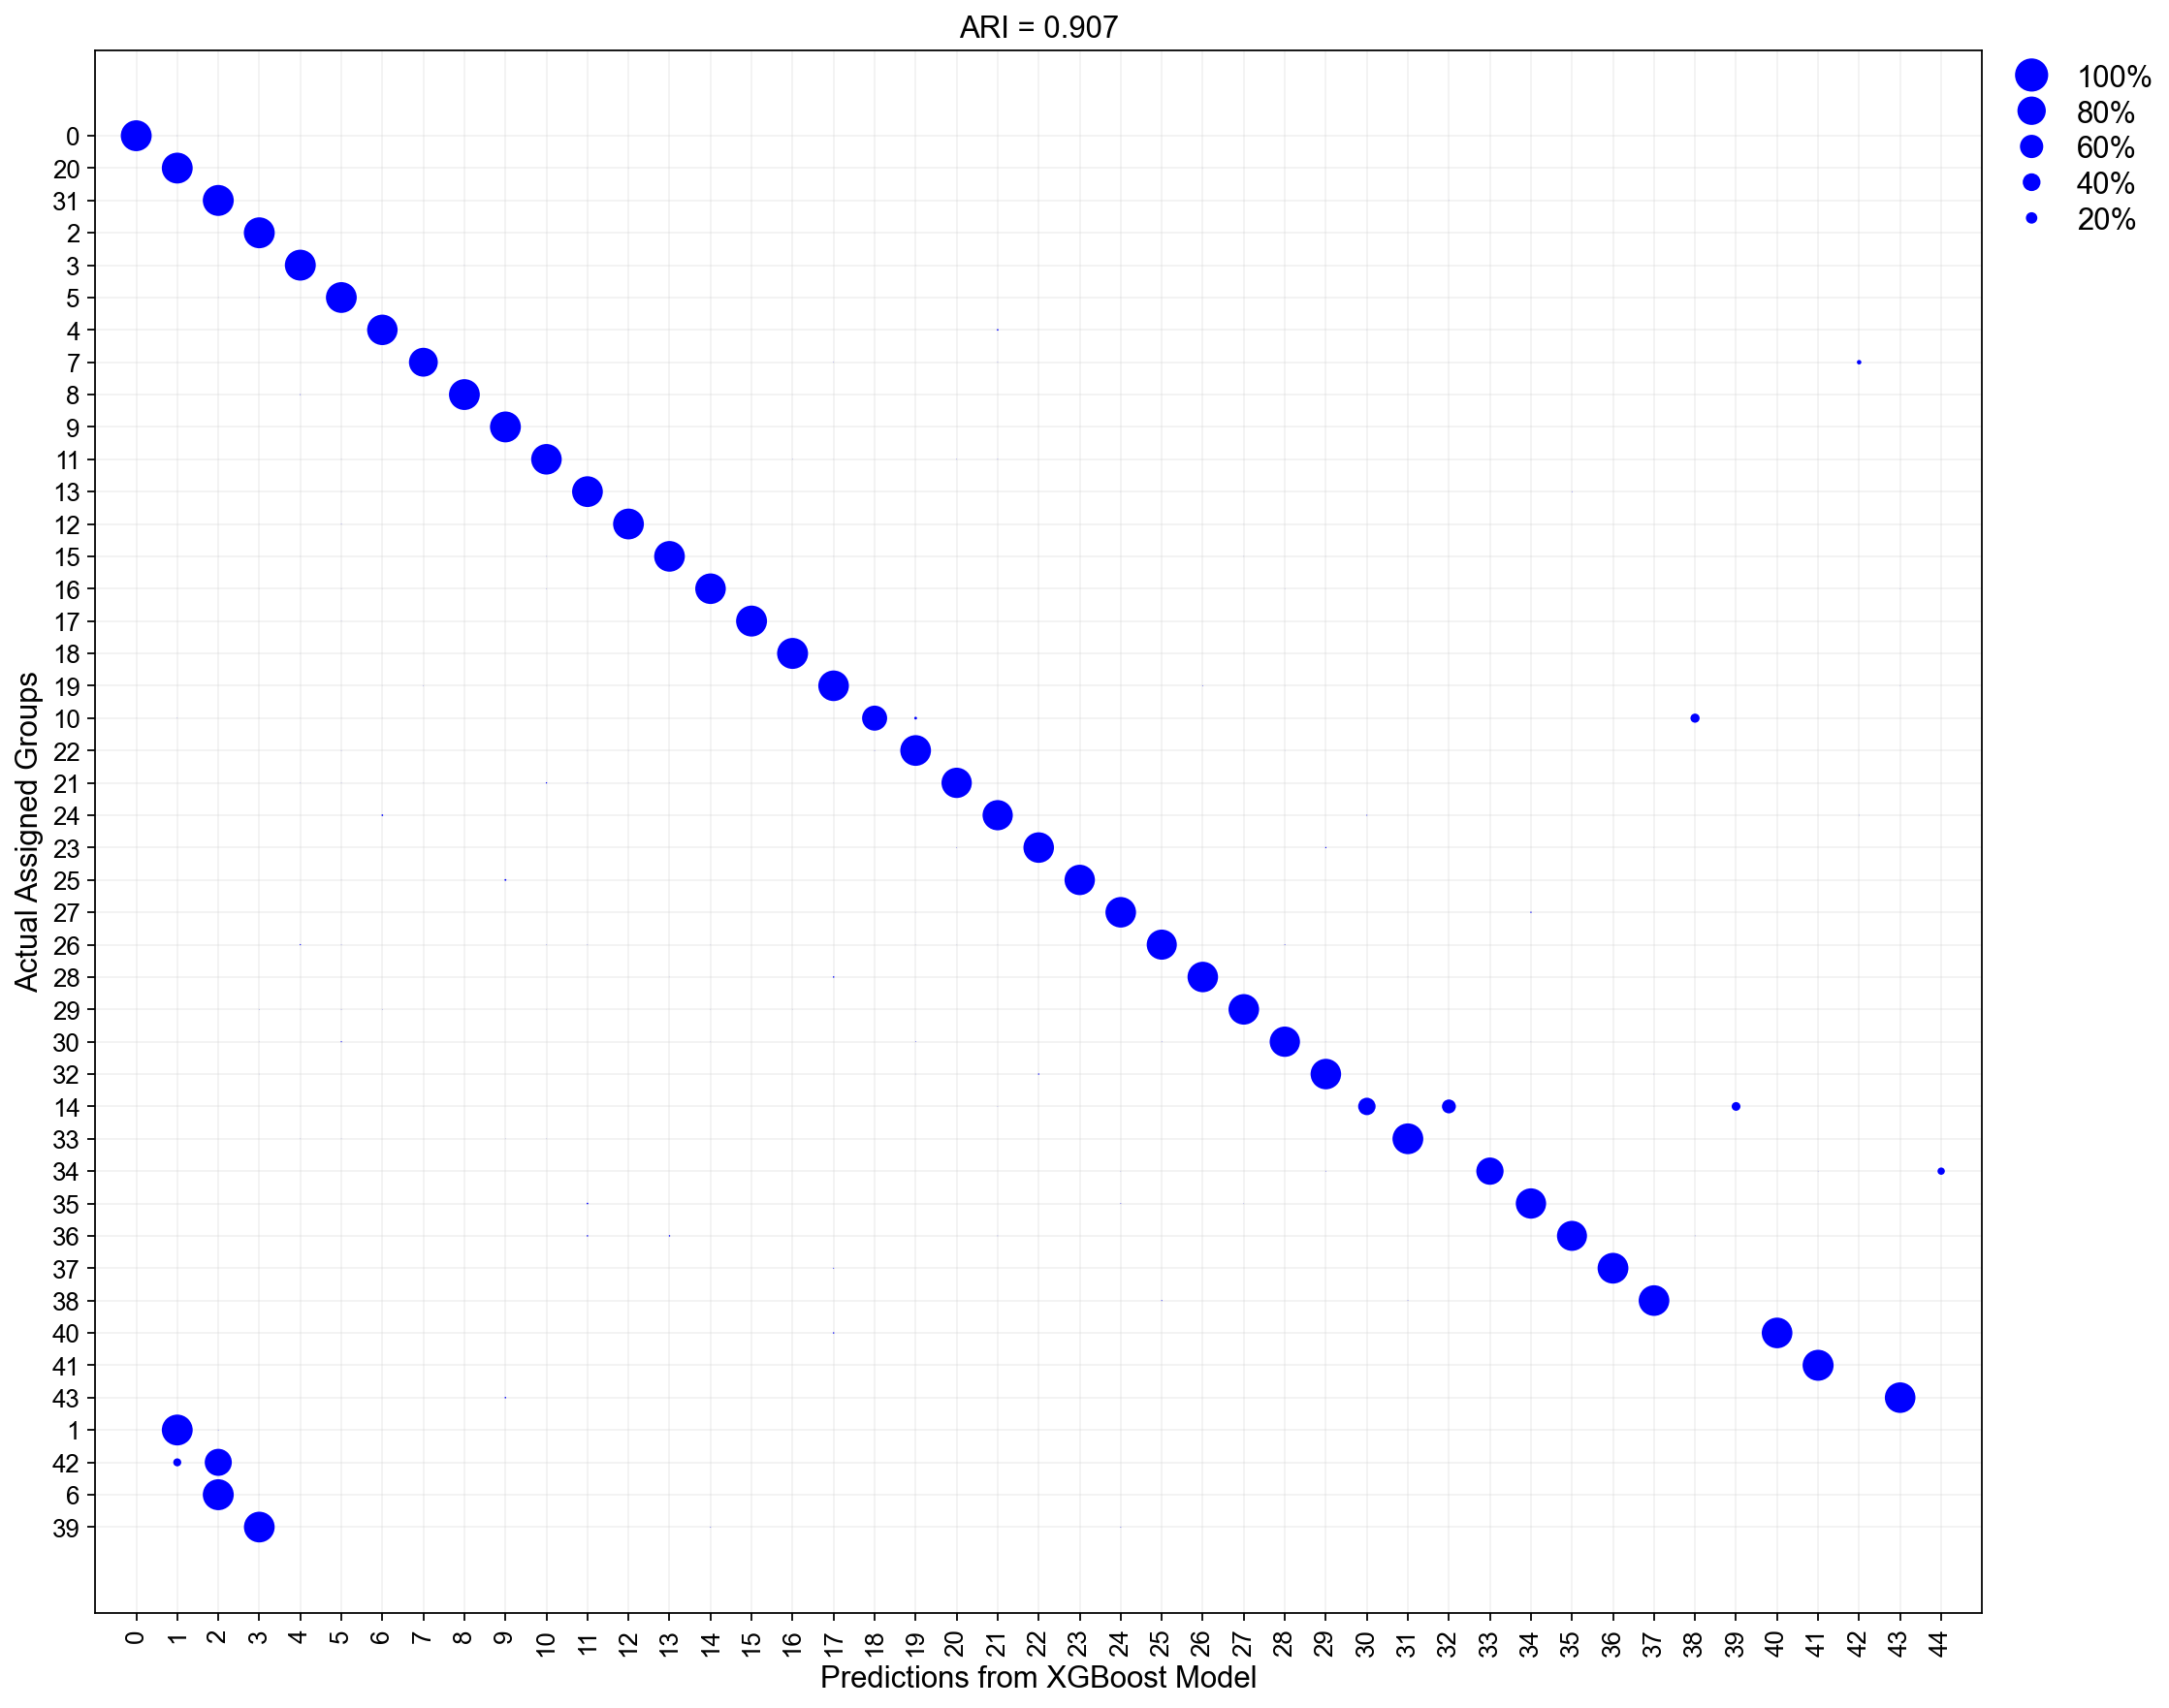

In [654]:
from sklearn.metrics.cluster import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec
import scanpy as sc

def plotConfusionMatrixNew(
    ytrue,
    ypred,
    type,
    xaxislabel,
    yaxislabel,
    title,
    train_dict,
    test_dict=None,
    re_order=None,
    re_order_cols = None,
    re_index = None,
    re_order_rows = None,
    save_as=None,
    ):
    # Note: Train classes = actual classes + unassigned
    # ytrue = independent clustering (test), ypred = classifier prediction (train)
    # Class labels must be nonnegative consecutive integers ranging from 0,1,...,n_classes-1


    numbertrainclasses = len(train_dict)
    numbertestclasses = len(test_dict)
    confusion_matrix = np.zeros((numbertestclasses,numbertrainclasses))
    for i,_ in enumerate(ytrue):
        confusion_matrix[ytrue[i],ypred[i]] += 1

    # Normalize confusion matrix
    for row,arr in enumerate(confusion_matrix):
        row_sum = np.sum(arr)
        if row_sum != 0:
            confusion_matrix[row] = confusion_matrix[row]/row_sum

    conf_df = pd.DataFrame(confusion_matrix)

    conf_df.index = list(test_dict.keys())
    conf_df.columns = list(train_dict.keys())

    if re_order:
        conf_df = conf_df[re_order_cols]
    # Reorder rows to try and make diagonal
    if re_index:
        most_likely = np.argmax(confusion_matrix, axis=0)
        row_order = list(dict.fromkeys(most_likely)) # Note: If one type is most likely for multiple rows, this will get rid of the duplicates
        inv_dict = {v:k for k,v in test_dict.items()}
        unclear_assignment = set(test_dict.values()) - set(most_likely)
        row_order.extend(unclear_assignment)
        row_order = [inv_dict[i] for i in row_order]
        conf_df = conf_df.reindex(row_order)
    diagcm = conf_df.to_numpy()


    xticksactual = list(conf_df.columns)

    dot_max = np.max(diagcm.flatten())
    dot_min = 0
    if dot_min != 0 or dot_max != 1:
        frac = np.clip(diagcm, dot_min, dot_max)
        old_range = dot_max - dot_min
        frac = (frac - dot_min) / old_range
    else:
        frac = diagcm
    xvalues = []
    yvalues = []
    sizes = []
    for i in range(diagcm.shape[0]):
        for j in range(diagcm.shape[1]):
            xvalues.append(j)
            yvalues.append(i)
            sizes.append((frac[i,j]*35)**1.5)
    size_legend_width = 0.5
    height = diagcm.shape[0] * 0.3 + 1
    height = max([1.5, height])
    heatmap_width = diagcm.shape[1] * 0.35
    width = (
        heatmap_width
        + size_legend_width
        )
    fig = plt.figure(figsize=(width, height))
    axs = gridspec.GridSpec(
        nrows=2,
        ncols=2,
        wspace=0.02,
        hspace=0.04,
        width_ratios=[
                    heatmap_width,
                    size_legend_width
                    ],
        height_ratios = [0.5, 10]
        )
    dot_ax = fig.add_subplot(axs[1, 0])
    dot_ax.scatter(xvalues,yvalues, s = sizes, c = 'blue', norm=None, edgecolor='none')
    y_ticks = range(diagcm.shape[0])
    dot_ax.set_yticks(y_ticks)
    if type == 'validation':
        dot_ax.set_yticklabels(list(train_dict.keys()))
    elif type == 'mapping':
        # dot_ax.set_yticklabels(list(test_dict.keys()))
        dot_ax.set_yticklabels(list(conf_df.index))
    x_ticks = range(diagcm.shape[1])
    dot_ax.set_xticks(x_ticks)
    dot_ax.set_xticklabels(xticksactual, rotation=90)
    dot_ax.tick_params(axis='both', labelsize='small')
    dot_ax.grid(True, linewidth = 0.2)
    dot_ax.set_axisbelow(True)
    dot_ax.set_xlim(-0.5, diagcm.shape[1] + 0.5)
    ymin, ymax = dot_ax.get_ylim()
    dot_ax.set_ylim(ymax + 0.5, ymin - 0.5)
    dot_ax.set_xlim(-1, diagcm.shape[1])
    dot_ax.set_xlabel(xaxislabel)
    dot_ax.set_ylabel(yaxislabel)
    dot_ax.set_title(title)
    size_legend_height = min(1.75, height)
    wspace = 10.5 / width
    axs3 = gridspec.GridSpecFromSubplotSpec(
        2,
        1,
        subplot_spec=axs[1, 1],
        wspace=wspace,
        height_ratios=[
                    size_legend_height / height,
                    (height - size_legend_height) / height
                    ]
        )
    diff = dot_max - dot_min
    if 0.3 < diff <= 0.6:
        step = 0.1
    elif diff <= 0.3:
        step = 0.05
    else:
        step = 0.2
    fracs_legends = np.arange(dot_max, dot_min, step * -1)[::-1]
    if dot_min != 0 or dot_max != 1:
        fracs_values = (fracs_legends - dot_min) / old_range
    else:
        fracs_values = fracs_legends
    size = (fracs_values * 35) ** 1.5
    size_legend = fig.add_subplot(axs3[0])
    size_legend.scatter(np.repeat(0, len(size)), range(len(size)), s=size, c = 'blue')
    size_legend.set_yticks(range(len(size)))
    labels = ["{:.0%}".format(x) for x in fracs_legends]
    if dot_max < 1:
        labels[-1] = ">" + labels[-1]
    size_legend.set_yticklabels(labels)
    size_legend.set_yticklabels(["{:.0%}".format(x) for x in fracs_legends])
    size_legend.tick_params(axis='y', left=False, labelleft=False, labelright=True)
    size_legend.tick_params(axis='x', bottom=False, labelbottom=False)
    size_legend.spines['right'].set_visible(False)
    size_legend.spines['top'].set_visible(False)
    size_legend.spines['left'].set_visible(False)
    size_legend.spines['bottom'].set_visible(False)
    size_legend.grid(False)
    ymin, ymax = size_legend.get_ylim()
    size_legend.set_ylim(ymin, ymax + 0.5)
    if save_as is not None:
        fig.savefig(save_as, bbox_inches = 'tight')
    plt.show()
    return diagcm, xticksactual, axs

def plot_mapping_new(test_labels, test_predlabels, test_dict, train_dict, 
                 xaxislabel, yaxislabel,
                re_order=None,
    re_order_cols = None,
                 re_index = None,
    re_order_rows = None, save_as=None):
    
    ARI = adjusted_rand_score(labels_true = test_labels, 
                              labels_pred = test_predlabels)
    
           
    mappingconfmat, mappingxticks, mappingplot = plotConfusionMatrixNew(
    ytrue = test_labels,
    ypred = test_predlabels,
    test_dict=test_dict,
    train_dict=train_dict,
    type = 'mapping',
    save_as = save_as,
    title = 'ARI = {:.3f}'.format(ARI),
    xaxislabel =xaxislabel,
    yaxislabel = yaxislabel,
        re_order=re_order,
    re_order_cols = re_order_cols,
        re_index = re_index,
    re_order_rows = re_order_rows,
    )    

if __name__ == "__main__":
    # train_dict is the label to class number for what you want on the x-axis
    # test_dict is the label to class number for what you want on the y-axis
    """First part just loads the data and creates the mapping dictionaries"""
    mer = sc.read_h5ad(r'C:\Users\daany\temp\RGC_only.h5ad') 
    train_dict = dict()
    for i in range(45):
        train_dict[str(i)] = i
#     train_dict['Unassigned'] = 45

    test_dict = dict()
    for i in range(np.max(adata.obs['leiden'].astype(int))+1):
        test_dict[str(i)] = i
    
    """Actually make the plots"""
    plot_mapping_new(test_labels=adata.obs['leiden'].astype(int).values, # ind_clust corresponds to test dict labels
             test_predlabels=adata.obs['Type_int'].astype(int).values, # cluster corresponds to train_dict labels
             test_dict=test_dict, 
             train_dict=train_dict,
             re_order=False,
             re_index=True,
                 xaxislabel='Predictions from XGBoost Model', yaxislabel='Actual Assigned Groups',
            save_as='clust_mapping.png')

In [650]:
adata.obs

,Type,Batch,Type_num,leiden,Type_int,preds
aRGC1_AAACCTGAGAATCTCC-1,C7,Batch1,C7,4,6,6
aRGC1_AAACCTGAGCGACGTA-1,C40_M1b,Batch1,C40,14,39,39
aRGC1_AAACCTGGTAAATGAC-1,C40_M1b,Batch1,C40,14,39,32
aRGC1_AAACCTGTCAAGGCTT-1,C27,Batch1,C27,28,26,26
aRGC1_AAACGGGAGCAGCGTA-1,C19,Batch1,C19,10,18,18
...,...,...,...,...,...,...
aRGC10_TTTGTCAAGGAACTGC-1,C2_W3D1,Batch3,C2,1,1,1
aRGC10_TTTGTCAAGTAGGTGC-1,C2_W3D1,Batch3,C2,1,1,1
aRGC10_TTTGTCACATGTAAGA-1,C8,Batch3,C8,7,7,7
aRGC10_TTTGTCAGTCTAGGTT-1,C3_FminiON,Batch3,C3,31,2,2
